<a href="https://colab.research.google.com/github/Plumz17/PCD_FinalProject/blob/main/PCD_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Digital Image Processing Final Project - Group 5
* Anders Emmanuel Tan (24/541351/PA/22964) KOMB
* Evan Razzan Adytaputra (24/545257/PA/23166) KOMB
* Indratanaya Budiman (24/534784/PA/22683) KOMA
* Daffa Maulana Siddiq (24/533358/PA/22569) KOMA


## 1. Setting Up Image to be Processed (Image Acquisition)


In [ ]:
#Cloning Github Repository to get the Image
!rm -rf PCD_FinalProject
!git clone https://github.com/Plumz17/PCD_FinalProject

Cloning into 'PCD_FinalProject'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 9), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 924.12 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
# #Upload Kaggle API to Download Dataset
# from google.colab import files
# files.upload()

In [ ]:
# #Download Dataset
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset
# !unzip tuberculosis-tb-chest-xray-dataset.zip -d TB_Dataset

In [ ]:
# Import Important Libraries
import cv2 # For Reading Image
import numpy as np # For Manipulating Image Matrix
import matplotlib.pyplot as plt # For Showing Image
import math # For Math
import os #Access Folder

filename_normal = "/content/PCD_FinalProject/normal.png"
filename_tbc = "/content/PCD_FinalProject/tbc.png"

img_normal = cv2.imread(filename_normal) # Read Image
img_normal = cv2.cvtColor(img_normal, cv2.COLOR_BGR2GRAY) # Change the color map

img_tbc = cv2.imread(filename_tbc) # Read Image
img_tbc = cv2.cvtColor(img_tbc, cv2.COLOR_BGR2GRAY) # Change the color map


In [ ]:
def show(before, after, title1="TBC", title2="Normal"): # Helper function to check the before and after of the enhancement
  plt.figure(figsize=(10,5))

   # Show original
  plt.subplot(1,2,1)
  plt.imshow(before, cmap='gray', vmin=0, vmax=255) #vmin and max to preserve original image's contrast
  plt.title(title1)
  plt.axis("off")

  # Show processed
  plt.subplot(1,2,2)
  plt.imshow(after, cmap='gray', vmin=0, vmax=255)
  plt.title(title2)
  plt.axis("off")

  plt.show()

## 2. Image Enhancement


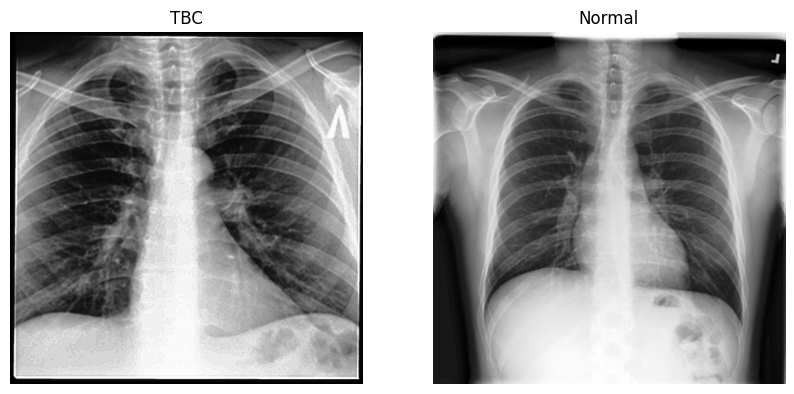

In [109]:
#Apply Gaussian Smoothing with a kernel of 5x5
img_tbc_gaussian = cv2.GaussianBlur(img_tbc, (5, 5), 0)
img_normal_gaussian = cv2.GaussianBlur(img_normal, (5, 5), 0)

#Additionally, Apply Laplacian Smoothing to highlight edges
laplacian_tbc = cv2.Laplacian(img_tbc_gaussian, cv2.CV_64F)
laplacian_normal = cv2.Laplacian(img_normal_gaussian, cv2.CV_64F)

#Sharpen Image by adding the edges from Laplacian Smoothing
img_tbc_sharpened = cv2.convertScaleAbs(img_tbc_gaussian - laplacian_tbc)
img_normal_sharpened = cv2.convertScaleAbs(img_normal_gaussian - laplacian_normal)

#Apply Histogram Equilization to Increase the Image's Contrast
img_tbc_hist = cv2.equalizeHist(img_tbc_sharpened)
img_normal_hist = cv2.equalizeHist(img_normal_sharpened)

show(img_tbc_hist, img_normal_hist)

## 3. Image Segmentation


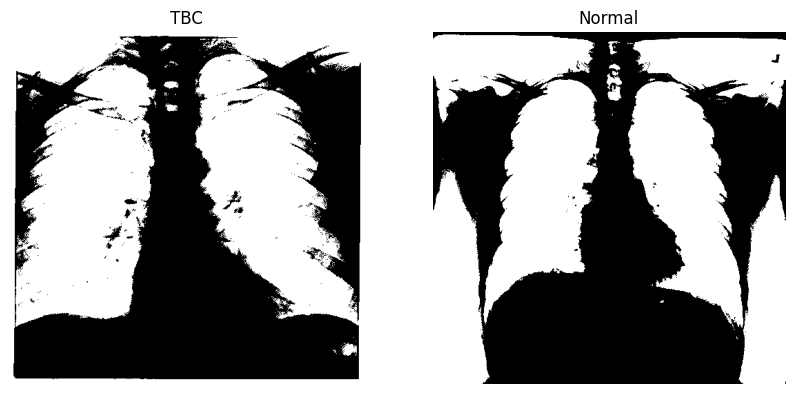

In [90]:
#Use Otsu Segmentation to Segment both Lungs
ret, img_tbc_seg = cv2.threshold(img_tbc_hist, 0, 255,cv2.THRESH_OTSU)
ret, img_normal_seg = cv2.threshold(img_normal_hist, 0, 255, cv2.THRESH_OTSU)

#Inverse the segmentation so we get the lungs as the foreground
img_tbc_seg = cv2.bitwise_not(img_tbc_seg)
img_normal_seg = cv2.bitwise_not(img_normal_seg)

show(img_tbc_seg, img_normal_seg)

## 4. Morphological Processes

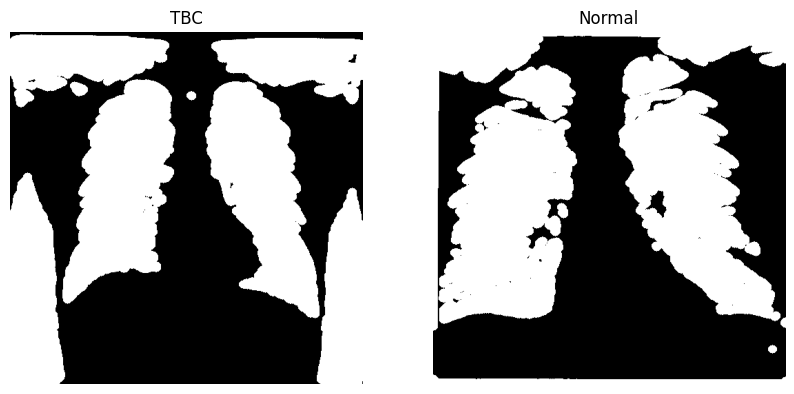

In [102]:
#Create Elipse Kernel to use in the Opening Algorithm
kernel_opening = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (13, 13))

#Execute Opening Algorithm to remove noise and seperate object
img_normal_opened = cv2.morphologyEx(img_normal_seg, cv2.MORPH_OPEN, kernel_opening)
img_tbc_opened = cv2.morphologyEx(img_tbc_seg, cv2.MORPH_OPEN, kernel_opening)

show(img_normal_opened, img_tbc_opened)

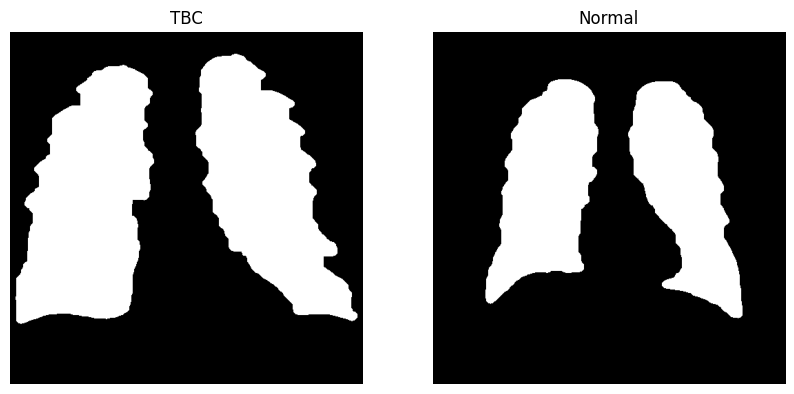

In [118]:
def select_lungs(segmented_image):
  # Find all connected components
  num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, 8, cv2.CV_32S)

  # The first component is usually the background, so we skip it.
  component_areas = []
  for i in range(1, num_labels):
    area = stats[i, cv2.CC_STAT_AREA]
    component_areas.append((area, i)) # Store (area, label_id)

  #Sort by
  component_areas.sort(key=lambda x: x[0], reverse=True)

  # Create blank images to hold the selected lungs
  lung1_image = np.zeros_like(segmented_image, dtype=np.uint8)
  lung2_image = np.zeros_like(segmented_image, dtype=np.uint8)

  # Select the two largest components (assuming they are the two lungs)
  if len(component_areas) >= 1:
    largest_component_id = component_areas[0][1]
    lung1_image[labels == largest_component_id] = 255
  if len(component_areas) >= 2:
    second_largest_component_id = component_areas[1][1]
    lung2_image[labels == second_largest_component_id] = 255

  return lung1_image, lung2_image

# Select lungs for TBC image
tbc_lung1, tbc_lung2 = select_lungs(img_tbc_opened)
tbc_lungs = cv2.add(tbc_lung1, tbc_lung2)

# Select lungs for Normal image
normal_lung1, normal_lung2 = select_lungs(img_normal_opened)
normal_lungs = cv2.add(normal_lung1, normal_lung2)

#Create Elipse Kernel to use in the Closing Algorithm
kernel_closing = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))

#Execute Closing Algorithm to fill in holes
img_normal_opened = cv2.morphologyEx(normal_lungs, cv2.MORPH_CLOSE, kernel_closing)
img_tbc_opened = cv2.morphologyEx(tbc_lungs, cv2.MORPH_CLOSE, kernel_closing)

show(img_tbc_opened, img_normal_opened)

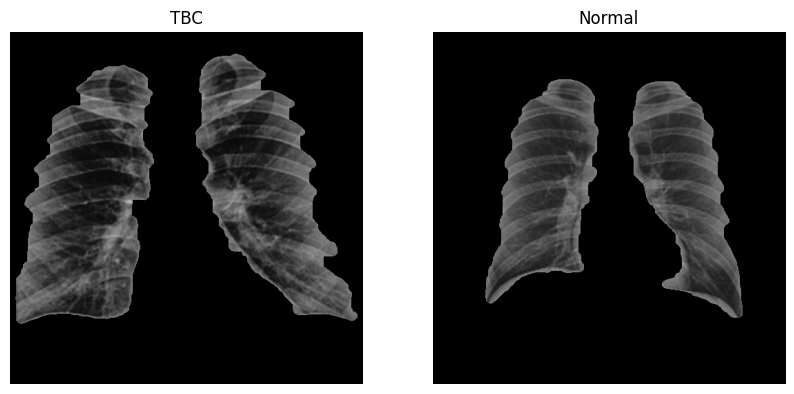

In [121]:
#Apply Mask using Bitwise And (The arguments are repeated since the function needs two arguments)
tbc_masked = cv2.bitwise_and(img_tbc_hist, img_tbc_hist, mask=img_tbc_opened)
normal_masked = cv2.bitwise_and(img_normal_hist, img_normal_hist, mask=img_normal_opened)

show(tbc_masked, normal_masked)

## 5. Feature Extraction

## 6. Representation and Matching

## 7. Train Model

In [ ]:
# Process all images in the dataset

# Define the directories for normal and TB images
normal_dir = "/content/TB_Dataset/TB_Chest_Radiography_Database/Tuberculosis"
tbc_dir = "/content/TB_Dataset/TB_Chest_Radiography_Database/Normal"

images = []
labels = []

# Function to process a single image
def process_image(image_path):
  img = cv2.imread(image_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img_hist = hist(img) # Apply histogram equalization
  img_segmented = segment(img_hist) # Apply Otsu thresholding
  #img_opened = opening(img_segmented, 3) # Apply morphological opening
  return img_segmented

# Process normal images
for filename in os.listdir(normal_dir):
  if filename.endswith(".png"): # Assuming images are in PNG format
    image_path = os.path.join(normal_dir, filename)
    processed_img = process_image(image_path)
    images.append(processed_img)
    labels.append(0) # 0 for normal

# Process TB images
for filename in os.listdir(tbc_dir):
  if filename.endswith(".png"): # Assuming images are in PNG format
    image_path = os.path.join(tbc_dir, filename)
    processed_img = process_image(image_path)
    images.append(processed_img)
    labels.append(1) # 1 for TB

print(f"Processed {len(images)} images.")

FileNotFoundError: [Errno 2] No such file or directory: '/content/TB_Dataset/TB_Chest_Radiography_Database/Tuberculosis'